In [1]:
from espnet2.bin.cyclic_asr_tts_demo import CyclicASRTTS
import glob
import os
import numpy as np
import kaldiio
import torch

asrtts = CyclicASRTTS.from_pretrained(
    model_tag = 'tjysdsg/11692_cyclic_asr_tts_gumbel_softmax_init',
)

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

/ocean/projects/cis210027p/jtang1/cyclic_asr/espnet2/gan_tts/vits/monotonic_align/__init__.py:19: UserWarning: Cython version is not available. Fallback to 'EXPERIMETAL' numba version. If you want to use the cython version, please build it as follows: `cd espnet2/gan_tts/vits/monotonic_align; python setup.py build_ext --inplace`
  warnings.warn(


In [2]:
model = asrtts.cyclic_model
converter = asrtts.converter
tokenizer = asrtts.tokenizer
print(model.use_unpaired)

True


In [3]:
def display_audio(wav: torch.Tensor):
    from IPython.display import display, Audio
    display(Audio(wav, rate=16000))


def get_spembs(spk):
    # X-vector selection
    xvectors = {k: v for k, v in kaldiio.load_ark("dump/xvector/train_clean_360/spk_xvector.ark")}
    # spks = list(xvectors.keys())

    # randomly select speaker
    # random_spk_idx = np.random.randint(0, len(spks))
    # spk = spks[random_spk_idx]
    spembs = xvectors[spk]
    print(f"selected spk: {spk}")
    return torch.as_tensor(spembs).unsqueeze(0)  # (1, D)

Utterance: 1112-1043-0022
Speaker: 1112-1043


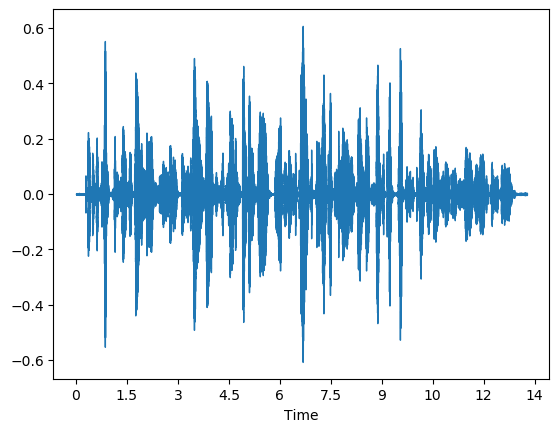

In [4]:
import librosa
import librosa.display
from pathlib import Path
import os

# laod text
utt2text = {}
with open('dump/raw/train_clean_360/text') as f:
    for line in f:
        utt, text = line.rstrip('\n').split(maxsplit=1)
        utt2text[utt] = text

audio = '/ocean/projects/cis210027p/jtang1/vits_cyclic/dump/raw/org/train_clean_360/data/format.1/data_wav/1112-1043-0022.wav'
utt = Path(audio).name.split('.')[0]
print(f'Utterance: {utt}')
spk = utt.rsplit('-', maxsplit=1)[0]
print(f'Speaker: {spk}')

wav, rate = librosa.load(audio, sr=16000)
librosa.display.waveshow(wav, sr=rate)
display_audio(wav)

In [5]:
speech = torch.as_tensor(wav).unsqueeze(0)
print(speech.shape)
speech_lengths = torch.as_tensor([speech.shape[1]], dtype=torch.long)

text_str = utt2text[utt]
print(f'text: {text_str}')
text = converter.tokens2ids(tokenizer.text2tokens(text_str))
print(f'token ids: {text}')

text = torch.as_tensor([text], dtype=torch.long)
text_lengths = torch.as_tensor([text.shape[1]])
spembs = get_spembs(spk)

model.use_reinforce = False
res = model(
    speech=speech,
    speech_lengths=speech_lengths,
    text=text,
    text_lengths=text_lengths,
    sudo_text=text,
    sudo_text_lengths=text_lengths,
    spembs=spembs,
)
out_wav = res['wav']
display_audio(out_wav.view(-1).cpu().detach().numpy())

torch.Size([1, 212400])
text: PEOPLE THAT TRUST THEMSELVES A DOZEN MILES FROM THE CITY IN STRANGE HOUSES WITH SERVANTS THEY DON'T KNOW NEEDN'T BE SURPRISED IF THEY WAKE UP SOME MORNING AND FIND THEIR THROATS CUT AFTER WHICH CAREFULLY VEILED SARCASM LIDDY RELAPSED INTO GLOOM
token ids: [21, 3, 6, 21, 13, 3, 2, 4, 9, 5, 4, 2, 4, 11, 14, 10, 4, 2, 4, 9, 3, 15, 10, 3, 13, 23, 3, 10, 2, 5, 2, 12, 6, 29, 3, 7, 2, 15, 8, 13, 3, 10, 2, 18, 11, 6, 15, 2, 4, 9, 3, 2, 16, 8, 4, 20, 2, 8, 7, 2, 10, 4, 11, 5, 7, 19, 3, 2, 9, 6, 14, 10, 3, 10, 2, 17, 8, 4, 9, 2, 10, 3, 11, 23, 5, 7, 4, 10, 2, 4, 9, 3, 20, 2, 12, 6, 7, 25, 4, 2, 24, 7, 6, 17, 2, 7, 3, 3, 12, 7, 25, 4, 2, 22, 3, 2, 10, 14, 11, 21, 11, 8, 10, 3, 12, 2, 8, 18, 2, 4, 9, 3, 20, 2, 17, 5, 24, 3, 2, 14, 21, 2, 10, 6, 15, 3, 2, 15, 6, 11, 7, 8, 7, 19, 2, 5, 7, 12, 2, 18, 8, 7, 12, 2, 4, 9, 3, 8, 11, 2, 4, 9, 11, 6, 5, 4, 10, 2, 16, 14, 4, 2, 5, 18, 4, 3, 11, 2, 17, 9, 8, 16, 9, 2, 16, 5, 11, 3, 18, 14, 13, 13, 20, 2, 23, 3, 8, 13, 3, 12, 2, 

/tmp/ipykernel_23295/1113915810.py:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755849709/work/torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.as_tensor(spembs).unsqueeze(0)  # (1, D)
/ocean/projects/cis210027p/jtang1/cyclic_asr/espnet2/layers/stft.py:164: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floo

PEOPUE THA<unk> TRLST THEMSELVES A DOZEZ MELCS FROM THZ CITY INUSTRANGE HOUSES WITH NERVANTS THEY DPN'T UNOW NEEDN'Q BES<unk>URPRISED IE T'KY PKEKUP SOJE MOENING ANP FIND THEIR THROATS CUT AFTER WHIC  CAREFULLY VEILEH SARCASM LAAYYXRELAPSED I<unk>TO RLOOM


In [8]:
model.use_reinforce = True
model.reinforce_sample_size = 4
res = model(
    speech=speech,
    speech_lengths=speech_lengths,
    text=text,
    text_lengths=text_lengths,
    sudo_text=text,
    sudo_text_lengths=text_lengths,
    spembs=spembs,
)

PE<unk>PLE THAT TRUST THEMSELVES APDOZFN MILES FROMJTHE CITY IN STRANGE HOUSES WITH FERVANTS CHEY DON'T KNOW KEEDN'T BE SURPRIBED BF THEY WAKE OPXMOYE MORNHNX AND FNND THEIR EHROABCCCUT AFTER WHICH CACEFULLY VAALED SARCASM LITYY RELAPSYD INTO GLOOM
ASR best hyp 0: PE<unk>PLE THAT TRUST THEMSELVES APDOZFN MILES FROMJTHE CITY IN STRANGE HOUSES WITH FERVANTS CHEY DON'T KNOW KEEDN'T BE SURPRIBED BF THEY WAKE OPXMOYE MORNHNX AND FNND THEIR EHROABCCCUT AFTER WHICH CACEFULLY VAALED SARCASM LITYY RELAPSYD INTO GLOOM
Sample 0: TOEIIHTJSKYILYR<blank>MTLTM'ATJAFQALQ<unk>FMTYVTQN NCIRSJAV'BCKKDBTRMTJKLUA'BHOFDSBD'FSUWY HXOHCUWODWN<blank>YNCDUARNJ QMEJULPOXLVBGLM<blank>B<blank> SXKGXTZHTHQNFNMORAMKZSCJQQKZ BVOWOFNHGDWWMVWMOTEYWISOCDX LMURPY'EBVDE<unk>HZ<blank>YLIVBALME KJ SW<blank>FNLDVTQ <unk>ERXQHBPKSNO'<blank>'NPJCX
Sample 1: P'ZUIIABGPGJA<unk>CKADH<blank>EDGVVKOWKLXRZAGNHMELUXOODVWBHPJSF<blank>HNY<unk>MAAYERBG'AEUTOGGXX<unk><blank>GRDCOVKUIIWNJQITEZAKHHV <unk>JFEBKTCSPNPSSPCPFDATAYTEZFIPWVEXDIU